In [1]:
try:
    from scikeras.wrappers import KerasRegressor                     
except ImportError:
    !pip install scikeras
    from scikeras.wrappers import KerasRegressor
    
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import sklearn
from sklearn.pipeline import Pipeline # for setting up a pre-processing / tuning pipeline.
from sklearn.preprocessing import RobustScaler # Here, we are going to normalize inputs (the ML Pipeline framework from sklearn can implement this.)

# So, we are going back to the Boston Housing data here.
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = (boston_housing.load_data())

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.10.1
    Uninstalling importlib-metadata-4.10.1:
      Successfully uninstalled importlib-metadata-4.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 3.10.1 which is incompatible.
65536/57026 [==================================] - 0s 0us/step


#*Grid Search CV With Keras Model*

In [3]:
# Make sure you set your custom parameters for training as arguments in your model creation function.
def create_model(optimizer="sgd",activation="relu",units=100,numLayers=2, batch_size=10):
    
    # I beleve that you need to explicitly declare an input layer for the scikeras wrapper to work... 
    model = keras.Sequential([
        layers.Input(train_data.shape[1]),
        layers.Dense(units, activation="relu")             
    ])

    if numLayers == 2:
        model.add(layers.Dense(units, activation="relu"))

    model.add(layers.Dense(1, activation=activation))

    model.compile(loss='mean_squared_error',optimizer=optimizer, metrics=['mse'])
    return model

# You also need to specify the 'custom' parameters here that you want to add, for them to show up as a trainable parameter in GridSearchCV.
regf = KerasRegressor(model=create_model, loss='mean_squared_error', optimizer="adam", activation="relu", units=100, numLayers=2, batch_size=10, verbose=0)

# Note you can also do a grid search over an sklearn pipeline, so you can search over diferent types of data pre-processing approaches too!
ml_pipeline = Pipeline([("Normalize_with_centering", RobustScaler()), ("Model", regf)])

# Here are the configurable parameters we can now search over for either object. 
print(regf.get_params().keys())
print(ml_pipeline.get_params().keys())

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'activation', 'units', 'numLayers'])
dict_keys(['memory', 'steps', 'verbose', 'Normalize_with_centering', 'Model', 'Normalize_with_centering__copy', 'Normalize_with_centering__quantile_range', 'Normalize_with_centering__unit_variance', 'Normalize_with_centering__with_centering', 'Normalize_with_centering__with_scaling', 'Model__model', 'Model__build_fn', 'Model__warm_start', 'Model__random_state', 'Model__optimizer', 'Model__loss', 'Model__metrics', 'Model__batch_size', 'Model__validation_batch_size', 'Model__verbose', 'Model__callbacks', 'Model__validation_split', 'Model__shuffle', 'Model__run_eagerly', 'Model__epochs', 'Model__activation', 'Model__units', 'Model__numLayers'])


And this is how I would invoke my grid search... 

In [4]:
from sklearn.model_selection import GridSearchCV
import numpy as np

# Because we are creating the models but are not compiling them yet (we will let the grid fit compile the models on the fly),
# this will produce a bunch of warnings. I'm just suppressing the warnings. 
#import logging, os
#logging.disable(logging.WARNING)
#os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

params = {
    "numLayers": [1,2],
    "units": [100,125,150],
    "activation": ['relu','selu',None],
    "batch_size": [25,50],
    "epochs": [10,20,30]
}

params_pipe = {
    "Model__numLayers": [1,2],
    "Model__units": [100,500],
    "Model__activation": ['relu','selu',None],
    "Model__batch_size": [25,50],
    "Model__epochs":[10,20,30]
}

grid = GridSearchCV(regf, params, scoring='neg_mean_absolute_error',verbose=11)#,cv=10)
#grid = GridSearchCV(ml_pipeline, params_pipe, scoring='neg_mean_absolute_error',verbose=11)#,cv=10)

grid.fit(train_data, train_targets)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5; 1/108] START activation=relu, batch_size=25, epochs=10, numLayers=1, units=100
[CV 1/5; 1/108] END activation=relu, batch_size=25, epochs=10, numLayers=1, units=100;, score=-20.121 total time=   4.9s
[CV 2/5; 1/108] START activation=relu, batch_size=25, epochs=10, numLayers=1, units=100
[CV 2/5; 1/108] END activation=relu, batch_size=25, epochs=10, numLayers=1, units=100;, score=-23.710 total time=   1.1s
[CV 3/5; 1/108] START activation=relu, batch_size=25, epochs=10, numLayers=1, units=100
[CV 3/5; 1/108] END activation=relu, batch_size=25, epochs=10, numLayers=1, units=100;, score=-21.856 total time=   0.8s
[CV 4/5; 1/108] START activation=relu, batch_size=25, epochs=10, numLayers=1, units=100
[CV 4/5; 1/108] END activation=relu, batch_size=25, epochs=10, numLayers=1, units=100;, score=-22.623 total time=   1.1s
[CV 5/5; 1/108] START activation=relu, batch_size=25, epochs=10, numLayers=1, units=100
[CV 5/5; 1/10

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 3/5; 74/108] END activation=None, batch_size=25, epochs=10, numLayers=1, units=125;, score=nan total time=   0.8s
[CV 4/5; 74/108] START activation=None, batch_size=25, epochs=10, numLayers=1, units=125


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 4/5; 74/108] END activation=None, batch_size=25, epochs=10, numLayers=1, units=125;, score=nan total time=   1.1s
[CV 5/5; 74/108] START activation=None, batch_size=25, epochs=10, numLayers=1, units=125
[CV 5/5; 74/108] END activation=None, batch_size=25, epochs=10, numLayers=1, units=125;, score=-291498.931 total time=   1.1s
[CV 1/5; 75/108] START activation=None, batch_size=25, epochs=10, numLayers=1, units=150
[CV 1/5; 75/108] END activation=None, batch_size=25, epochs=10, numLayers=1, units=150;, score=-1922335.871 total time=   0.8s
[CV 2/5; 75/108] START activation=None, batch_size=25, epochs=10, numLayers=1, units=150
[CV 2/5; 75/108] END activation=None, batch_size=25, epochs=10, numLayers=1, units=150;, score=-4395695.210 total time=   0.8s
[CV 3/5; 75/108] START activation=None, batch_size=25, epochs=10, numLayers=1, units=150
[CV 3/5; 75/108] END activation=None, batch_size=25, epochs=10, numLayers=1, units=150;, score=-447796871146.144 total time=   0.8s
[CV 4/5; 75/10

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 1/5; 76/108] END activation=None, batch_size=25, epochs=10, numLayers=2, units=100;, score=nan total time=   1.2s
[CV 2/5; 76/108] START activation=None, batch_size=25, epochs=10, numLayers=2, units=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 2/5; 76/108] END activation=None, batch_size=25, epochs=10, numLayers=2, units=100;, score=nan total time=   0.9s
[CV 3/5; 76/108] START activation=None, batch_size=25, epochs=10, numLayers=2, units=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 3/5; 76/108] END activation=None, batch_size=25, epochs=10, numLayers=2, units=100;, score=nan total time=   1.2s
[CV 4/5; 76/108] START activation=None, batch_size=25, epochs=10, numLayers=2, units=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 4/5; 76/108] END activation=None, batch_size=25, epochs=10, numLayers=2, units=100;, score=nan total time=   0.9s
[CV 5/5; 76/108] START activation=None, batch_size=25, epochs=10, numLayers=2, units=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 5/5; 76/108] END activation=None, batch_size=25, epochs=10, numLayers=2, units=100;, score=nan total time=   0.9s
[CV 1/5; 77/108] START activation=None, batch_size=25, epochs=10, numLayers=2, units=125


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 1/5; 77/108] END activation=None, batch_size=25, epochs=10, numLayers=2, units=125;, score=nan total time=   1.1s
[CV 2/5; 77/108] START activation=None, batch_size=25, epochs=10, numLayers=2, units=125


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 2/5; 77/108] END activation=None, batch_size=25, epochs=10, numLayers=2, units=125;, score=nan total time=   0.9s
[CV 3/5; 77/108] START activation=None, batch_size=25, epochs=10, numLayers=2, units=125


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 3/5; 77/108] END activation=None, batch_size=25, epochs=10, numLayers=2, units=125;, score=nan total time=   0.9s
[CV 4/5; 77/108] START activation=None, batch_size=25, epochs=10, numLayers=2, units=125


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 4/5; 77/108] END activation=None, batch_size=25, epochs=10, numLayers=2, units=125;, score=nan total time=   1.1s
[CV 5/5; 77/108] START activation=None, batch_size=25, epochs=10, numLayers=2, units=125


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 5/5; 77/108] END activation=None, batch_size=25, epochs=10, numLayers=2, units=125;, score=nan total time=   0.9s
[CV 1/5; 78/108] START activation=None, batch_size=25, epochs=10, numLayers=2, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 1/5; 78/108] END activation=None, batch_size=25, epochs=10, numLayers=2, units=150;, score=nan total time=   1.2s
[CV 2/5; 78/108] START activation=None, batch_size=25, epochs=10, numLayers=2, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 2/5; 78/108] END activation=None, batch_size=25, epochs=10, numLayers=2, units=150;, score=nan total time=   1.1s
[CV 3/5; 78/108] START activation=None, batch_size=25, epochs=10, numLayers=2, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 3/5; 78/108] END activation=None, batch_size=25, epochs=10, numLayers=2, units=150;, score=nan total time=   1.1s
[CV 4/5; 78/108] START activation=None, batch_size=25, epochs=10, numLayers=2, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 4/5; 78/108] END activation=None, batch_size=25, epochs=10, numLayers=2, units=150;, score=nan total time=   0.9s
[CV 5/5; 78/108] START activation=None, batch_size=25, epochs=10, numLayers=2, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 5/5; 78/108] END activation=None, batch_size=25, epochs=10, numLayers=2, units=150;, score=nan total time=   1.4s
[CV 1/5; 79/108] START activation=None, batch_size=25, epochs=20, numLayers=1, units=100
[CV 1/5; 79/108] END activation=None, batch_size=25, epochs=20, numLayers=1, units=100;, score=-495970615275.879 total time=   1.1s
[CV 2/5; 79/108] START activation=None, batch_size=25, epochs=20, numLayers=1, units=100
[CV 2/5; 79/108] END activation=None, batch_size=25, epochs=20, numLayers=1, units=100;, score=-3515666664.290 total time=   1.7s
[CV 3/5; 79/108] START activation=None, batch_size=25, epochs=20, numLayers=1, units=100
[CV 3/5; 79/108] END activation=None, batch_size=25, epochs=20, numLayers=1, units=100;, score=-80501413842518032.000 total time=   1.1s
[CV 4/5; 79/108] START activation=None, batch_size=25, epochs=20, numLayers=1, units=100
[CV 4/5; 79/108] END activation=None, batch_size=25, epochs=20, numLayers=1, units=100;, score=-235050385385.377 total time=   

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 5/5; 80/108] END activation=None, batch_size=25, epochs=20, numLayers=1, units=125;, score=nan total time=   1.1s
[CV 1/5; 81/108] START activation=None, batch_size=25, epochs=20, numLayers=1, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 1/5; 81/108] END activation=None, batch_size=25, epochs=20, numLayers=1, units=150;, score=nan total time=   1.7s
[CV 2/5; 81/108] START activation=None, batch_size=25, epochs=20, numLayers=1, units=150
[CV 2/5; 81/108] END activation=None, batch_size=25, epochs=20, numLayers=1, units=150;, score=-1532207955991.710 total time=   1.1s
[CV 3/5; 81/108] START activation=None, batch_size=25, epochs=20, numLayers=1, units=150
[CV 3/5; 81/108] END activation=None, batch_size=25, epochs=20, numLayers=1, units=150;, score=-81995375266758640.000 total time=   1.8s
[CV 4/5; 81/108] START activation=None, batch_size=25, epochs=20, numLayers=1, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 4/5; 81/108] END activation=None, batch_size=25, epochs=20, numLayers=1, units=150;, score=nan total time=   1.1s
[CV 5/5; 81/108] START activation=None, batch_size=25, epochs=20, numLayers=1, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 5/5; 81/108] END activation=None, batch_size=25, epochs=20, numLayers=1, units=150;, score=nan total time=   1.1s
[CV 1/5; 82/108] START activation=None, batch_size=25, epochs=20, numLayers=2, units=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 1/5; 82/108] END activation=None, batch_size=25, epochs=20, numLayers=2, units=100;, score=nan total time=   1.8s
[CV 2/5; 82/108] START activation=None, batch_size=25, epochs=20, numLayers=2, units=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 2/5; 82/108] END activation=None, batch_size=25, epochs=20, numLayers=2, units=100;, score=nan total time=   1.8s
[CV 3/5; 82/108] START activation=None, batch_size=25, epochs=20, numLayers=2, units=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 3/5; 82/108] END activation=None, batch_size=25, epochs=20, numLayers=2, units=100;, score=nan total time=   2.1s
[CV 4/5; 82/108] START activation=None, batch_size=25, epochs=20, numLayers=2, units=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 4/5; 82/108] END activation=None, batch_size=25, epochs=20, numLayers=2, units=100;, score=nan total time=   1.2s
[CV 5/5; 82/108] START activation=None, batch_size=25, epochs=20, numLayers=2, units=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 5/5; 82/108] END activation=None, batch_size=25, epochs=20, numLayers=2, units=100;, score=nan total time=   1.8s
[CV 1/5; 83/108] START activation=None, batch_size=25, epochs=20, numLayers=2, units=125


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 1/5; 83/108] END activation=None, batch_size=25, epochs=20, numLayers=2, units=125;, score=nan total time=   1.8s
[CV 2/5; 83/108] START activation=None, batch_size=25, epochs=20, numLayers=2, units=125


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 2/5; 83/108] END activation=None, batch_size=25, epochs=20, numLayers=2, units=125;, score=nan total time=   1.8s
[CV 3/5; 83/108] START activation=None, batch_size=25, epochs=20, numLayers=2, units=125


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 3/5; 83/108] END activation=None, batch_size=25, epochs=20, numLayers=2, units=125;, score=nan total time=   1.2s
[CV 4/5; 83/108] START activation=None, batch_size=25, epochs=20, numLayers=2, units=125


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 4/5; 83/108] END activation=None, batch_size=25, epochs=20, numLayers=2, units=125;, score=nan total time=   1.8s
[CV 5/5; 83/108] START activation=None, batch_size=25, epochs=20, numLayers=2, units=125


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 5/5; 83/108] END activation=None, batch_size=25, epochs=20, numLayers=2, units=125;, score=nan total time=   1.8s
[CV 1/5; 84/108] START activation=None, batch_size=25, epochs=20, numLayers=2, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 1/5; 84/108] END activation=None, batch_size=25, epochs=20, numLayers=2, units=150;, score=nan total time=   1.8s
[CV 2/5; 84/108] START activation=None, batch_size=25, epochs=20, numLayers=2, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 2/5; 84/108] END activation=None, batch_size=25, epochs=20, numLayers=2, units=150;, score=nan total time=   1.8s
[CV 3/5; 84/108] START activation=None, batch_size=25, epochs=20, numLayers=2, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 3/5; 84/108] END activation=None, batch_size=25, epochs=20, numLayers=2, units=150;, score=nan total time=   1.8s
[CV 4/5; 84/108] START activation=None, batch_size=25, epochs=20, numLayers=2, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 4/5; 84/108] END activation=None, batch_size=25, epochs=20, numLayers=2, units=150;, score=nan total time=   1.8s
[CV 5/5; 84/108] START activation=None, batch_size=25, epochs=20, numLayers=2, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 5/5; 84/108] END activation=None, batch_size=25, epochs=20, numLayers=2, units=150;, score=nan total time=   1.2s
[CV 1/5; 85/108] START activation=None, batch_size=25, epochs=30, numLayers=1, units=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 1/5; 85/108] END activation=None, batch_size=25, epochs=30, numLayers=1, units=100;, score=nan total time=   1.7s
[CV 2/5; 85/108] START activation=None, batch_size=25, epochs=30, numLayers=1, units=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 2/5; 85/108] END activation=None, batch_size=25, epochs=30, numLayers=1, units=100;, score=nan total time=   1.8s
[CV 3/5; 85/108] START activation=None, batch_size=25, epochs=30, numLayers=1, units=100
[CV 3/5; 85/108] END activation=None, batch_size=25, epochs=30, numLayers=1, units=100;, score=-128.055 total time=   1.4s
[CV 4/5; 85/108] START activation=None, batch_size=25, epochs=30, numLayers=1, units=100
[CV 4/5; 85/108] END activation=None, batch_size=25, epochs=30, numLayers=1, units=100;, score=-51216209936361.375 total time=   1.7s
[CV 5/5; 85/108] START activation=None, batch_size=25, epochs=30, numLayers=1, units=100
[CV 5/5; 85/108] END activation=None, batch_size=25, epochs=30, numLayers=1, units=100;, score=-2045634941026280.000 total time=   2.1s
[CV 1/5; 86/108] START activation=None, batch_size=25, epochs=30, numLayers=1, units=125
[CV 1/5; 86/108] END activation=None, batch_size=25, epochs=30, numLayers=1, units=125;, score=-9705316417556.121 total time=   1.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 2/5; 86/108] END activation=None, batch_size=25, epochs=30, numLayers=1, units=125;, score=nan total time=   1.7s
[CV 3/5; 86/108] START activation=None, batch_size=25, epochs=30, numLayers=1, units=125
[CV 3/5; 86/108] END activation=None, batch_size=25, epochs=30, numLayers=1, units=125;, score=-445.071 total time=   1.4s
[CV 4/5; 86/108] START activation=None, batch_size=25, epochs=30, numLayers=1, units=125
[CV 4/5; 86/108] END activation=None, batch_size=25, epochs=30, numLayers=1, units=125;, score=-5198239183667222.000 total time=   1.7s
[CV 5/5; 86/108] START activation=None, batch_size=25, epochs=30, numLayers=1, units=125


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 5/5; 86/108] END activation=None, batch_size=25, epochs=30, numLayers=1, units=125;, score=nan total time=   1.4s
[CV 1/5; 87/108] START activation=None, batch_size=25, epochs=30, numLayers=1, units=150
[CV 1/5; 87/108] END activation=None, batch_size=25, epochs=30, numLayers=1, units=150;, score=-678901483.879 total time=   1.4s
[CV 2/5; 87/108] START activation=None, batch_size=25, epochs=30, numLayers=1, units=150
[CV 2/5; 87/108] END activation=None, batch_size=25, epochs=30, numLayers=1, units=150;, score=-1051472680.290 total time=   1.7s
[CV 3/5; 87/108] START activation=None, batch_size=25, epochs=30, numLayers=1, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 3/5; 87/108] END activation=None, batch_size=25, epochs=30, numLayers=1, units=150;, score=nan total time=   1.4s
[CV 4/5; 87/108] START activation=None, batch_size=25, epochs=30, numLayers=1, units=150
[CV 4/5; 87/108] END activation=None, batch_size=25, epochs=30, numLayers=1, units=150;, score=-121188533665814.594 total time=   1.5s
[CV 5/5; 87/108] START activation=None, batch_size=25, epochs=30, numLayers=1, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 5/5; 87/108] END activation=None, batch_size=25, epochs=30, numLayers=1, units=150;, score=nan total time=   1.4s
[CV 1/5; 88/108] START activation=None, batch_size=25, epochs=30, numLayers=2, units=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 1/5; 88/108] END activation=None, batch_size=25, epochs=30, numLayers=2, units=100;, score=nan total time=   1.8s
[CV 2/5; 88/108] START activation=None, batch_size=25, epochs=30, numLayers=2, units=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 2/5; 88/108] END activation=None, batch_size=25, epochs=30, numLayers=2, units=100;, score=nan total time=   1.8s
[CV 3/5; 88/108] START activation=None, batch_size=25, epochs=30, numLayers=2, units=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 3/5; 88/108] END activation=None, batch_size=25, epochs=30, numLayers=2, units=100;, score=nan total time=   1.8s
[CV 4/5; 88/108] START activation=None, batch_size=25, epochs=30, numLayers=2, units=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 4/5; 88/108] END activation=None, batch_size=25, epochs=30, numLayers=2, units=100;, score=nan total time=   1.8s
[CV 5/5; 88/108] START activation=None, batch_size=25, epochs=30, numLayers=2, units=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 5/5; 88/108] END activation=None, batch_size=25, epochs=30, numLayers=2, units=100;, score=nan total time=   1.8s
[CV 1/5; 89/108] START activation=None, batch_size=25, epochs=30, numLayers=2, units=125


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 1/5; 89/108] END activation=None, batch_size=25, epochs=30, numLayers=2, units=125;, score=nan total time=   1.8s
[CV 2/5; 89/108] START activation=None, batch_size=25, epochs=30, numLayers=2, units=125


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 2/5; 89/108] END activation=None, batch_size=25, epochs=30, numLayers=2, units=125;, score=nan total time=   1.9s
[CV 3/5; 89/108] START activation=None, batch_size=25, epochs=30, numLayers=2, units=125


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 3/5; 89/108] END activation=None, batch_size=25, epochs=30, numLayers=2, units=125;, score=nan total time=   1.5s
[CV 4/5; 89/108] START activation=None, batch_size=25, epochs=30, numLayers=2, units=125


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 4/5; 89/108] END activation=None, batch_size=25, epochs=30, numLayers=2, units=125;, score=nan total time=   1.8s
[CV 5/5; 89/108] START activation=None, batch_size=25, epochs=30, numLayers=2, units=125


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 5/5; 89/108] END activation=None, batch_size=25, epochs=30, numLayers=2, units=125;, score=nan total time=   1.8s
[CV 1/5; 90/108] START activation=None, batch_size=25, epochs=30, numLayers=2, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 1/5; 90/108] END activation=None, batch_size=25, epochs=30, numLayers=2, units=150;, score=nan total time=   1.5s
[CV 2/5; 90/108] START activation=None, batch_size=25, epochs=30, numLayers=2, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 2/5; 90/108] END activation=None, batch_size=25, epochs=30, numLayers=2, units=150;, score=nan total time=   1.8s
[CV 3/5; 90/108] START activation=None, batch_size=25, epochs=30, numLayers=2, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 3/5; 90/108] END activation=None, batch_size=25, epochs=30, numLayers=2, units=150;, score=nan total time=   1.5s
[CV 4/5; 90/108] START activation=None, batch_size=25, epochs=30, numLayers=2, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 4/5; 90/108] END activation=None, batch_size=25, epochs=30, numLayers=2, units=150;, score=nan total time=   1.5s
[CV 5/5; 90/108] START activation=None, batch_size=25, epochs=30, numLayers=2, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 5/5; 90/108] END activation=None, batch_size=25, epochs=30, numLayers=2, units=150;, score=nan total time=   1.8s
[CV 1/5; 91/108] START activation=None, batch_size=50, epochs=10, numLayers=1, units=100
[CV 1/5; 91/108] END activation=None, batch_size=50, epochs=10, numLayers=1, units=100;, score=-16250974502891.883 total time=   0.8s
[CV 2/5; 91/108] START activation=None, batch_size=50, epochs=10, numLayers=1, units=100
[CV 2/5; 91/108] END activation=None, batch_size=50, epochs=10, numLayers=1, units=100;, score=-1451446.665 total time=   0.8s
[CV 3/5; 91/108] START activation=None, batch_size=50, epochs=10, numLayers=1, units=100
[CV 3/5; 91/108] END activation=None, batch_size=50, epochs=10, numLayers=1, units=100;, score=-61872997.856 total time=   0.8s
[CV 4/5; 91/108] START activation=None, batch_size=50, epochs=10, numLayers=1, units=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 4/5; 91/108] END activation=None, batch_size=50, epochs=10, numLayers=1, units=100;, score=nan total time=   0.8s
[CV 5/5; 91/108] START activation=None, batch_size=50, epochs=10, numLayers=1, units=100
[CV 5/5; 91/108] END activation=None, batch_size=50, epochs=10, numLayers=1, units=100;, score=-361277128727.681 total time=   0.8s
[CV 1/5; 92/108] START activation=None, batch_size=50, epochs=10, numLayers=1, units=125
[CV 1/5; 92/108] END activation=None, batch_size=50, epochs=10, numLayers=1, units=125;, score=-111838.192 total time=   0.7s
[CV 2/5; 92/108] START activation=None, batch_size=50, epochs=10, numLayers=1, units=125
[CV 2/5; 92/108] END activation=None, batch_size=50, epochs=10, numLayers=1, units=125;, score=-4146672104.290 total time=   0.8s
[CV 3/5; 92/108] START activation=None, batch_size=50, epochs=10, numLayers=1, units=125
[CV 3/5; 92/108] END activation=None, batch_size=50, epochs=10, numLayers=1, units=125;, score=-164401.215 total time=   0.8s
[CV 4/5; 92/

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 1/5; 93/108] END activation=None, batch_size=50, epochs=10, numLayers=1, units=150;, score=nan total time=   0.7s
[CV 2/5; 93/108] START activation=None, batch_size=50, epochs=10, numLayers=1, units=150
[CV 2/5; 93/108] END activation=None, batch_size=50, epochs=10, numLayers=1, units=150;, score=-2298714600452915200.000 total time=   0.7s
[CV 3/5; 93/108] START activation=None, batch_size=50, epochs=10, numLayers=1, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 3/5; 93/108] END activation=None, batch_size=50, epochs=10, numLayers=1, units=150;, score=nan total time=   0.8s
[CV 4/5; 93/108] START activation=None, batch_size=50, epochs=10, numLayers=1, units=150
[CV 4/5; 93/108] END activation=None, batch_size=50, epochs=10, numLayers=1, units=150;, score=-64635764758.623 total time=   0.8s
[CV 5/5; 93/108] START activation=None, batch_size=50, epochs=10, numLayers=1, units=150
[CV 5/5; 93/108] END activation=None, batch_size=50, epochs=10, numLayers=1, units=150;, score=-220755159550261198848.000 total time=   0.7s
[CV 1/5; 94/108] START activation=None, batch_size=50, epochs=10, numLayers=2, units=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 1/5; 94/108] END activation=None, batch_size=50, epochs=10, numLayers=2, units=100;, score=nan total time=   0.8s
[CV 2/5; 94/108] START activation=None, batch_size=50, epochs=10, numLayers=2, units=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 2/5; 94/108] END activation=None, batch_size=50, epochs=10, numLayers=2, units=100;, score=nan total time=   0.8s
[CV 3/5; 94/108] START activation=None, batch_size=50, epochs=10, numLayers=2, units=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 3/5; 94/108] END activation=None, batch_size=50, epochs=10, numLayers=2, units=100;, score=nan total time=   0.8s
[CV 4/5; 94/108] START activation=None, batch_size=50, epochs=10, numLayers=2, units=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 4/5; 94/108] END activation=None, batch_size=50, epochs=10, numLayers=2, units=100;, score=nan total time=   0.8s
[CV 5/5; 94/108] START activation=None, batch_size=50, epochs=10, numLayers=2, units=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 5/5; 94/108] END activation=None, batch_size=50, epochs=10, numLayers=2, units=100;, score=nan total time=   0.7s
[CV 1/5; 95/108] START activation=None, batch_size=50, epochs=10, numLayers=2, units=125


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 1/5; 95/108] END activation=None, batch_size=50, epochs=10, numLayers=2, units=125;, score=nan total time=   0.8s
[CV 2/5; 95/108] START activation=None, batch_size=50, epochs=10, numLayers=2, units=125


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 2/5; 95/108] END activation=None, batch_size=50, epochs=10, numLayers=2, units=125;, score=nan total time=   0.8s
[CV 3/5; 95/108] START activation=None, batch_size=50, epochs=10, numLayers=2, units=125


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 3/5; 95/108] END activation=None, batch_size=50, epochs=10, numLayers=2, units=125;, score=nan total time=   0.8s
[CV 4/5; 95/108] START activation=None, batch_size=50, epochs=10, numLayers=2, units=125


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 4/5; 95/108] END activation=None, batch_size=50, epochs=10, numLayers=2, units=125;, score=nan total time=   0.7s
[CV 5/5; 95/108] START activation=None, batch_size=50, epochs=10, numLayers=2, units=125


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 5/5; 95/108] END activation=None, batch_size=50, epochs=10, numLayers=2, units=125;, score=nan total time=   0.7s
[CV 1/5; 96/108] START activation=None, batch_size=50, epochs=10, numLayers=2, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 1/5; 96/108] END activation=None, batch_size=50, epochs=10, numLayers=2, units=150;, score=nan total time=   0.8s
[CV 2/5; 96/108] START activation=None, batch_size=50, epochs=10, numLayers=2, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 2/5; 96/108] END activation=None, batch_size=50, epochs=10, numLayers=2, units=150;, score=nan total time=   1.1s
[CV 3/5; 96/108] START activation=None, batch_size=50, epochs=10, numLayers=2, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 3/5; 96/108] END activation=None, batch_size=50, epochs=10, numLayers=2, units=150;, score=nan total time=   0.8s
[CV 4/5; 96/108] START activation=None, batch_size=50, epochs=10, numLayers=2, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 4/5; 96/108] END activation=None, batch_size=50, epochs=10, numLayers=2, units=150;, score=nan total time=   0.8s
[CV 5/5; 96/108] START activation=None, batch_size=50, epochs=10, numLayers=2, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 5/5; 96/108] END activation=None, batch_size=50, epochs=10, numLayers=2, units=150;, score=nan total time=   0.8s
[CV 1/5; 97/108] START activation=None, batch_size=50, epochs=20, numLayers=1, units=100
[CV 1/5; 97/108] END activation=None, batch_size=50, epochs=20, numLayers=1, units=100;, score=-25565724109963284.000 total time=   1.1s
[CV 2/5; 97/108] START activation=None, batch_size=50, epochs=20, numLayers=1, units=100
[CV 2/5; 97/108] END activation=None, batch_size=50, epochs=20, numLayers=1, units=100;, score=-99652.866 total time=   0.8s
[CV 3/5; 97/108] START activation=None, batch_size=50, epochs=20, numLayers=1, units=100
[CV 3/5; 97/108] END activation=None, batch_size=50, epochs=20, numLayers=1, units=100;, score=-147428.285 total time=   0.9s
[CV 4/5; 97/108] START activation=None, batch_size=50, epochs=20, numLayers=1, units=100
[CV 4/5; 97/108] END activation=None, batch_size=50, epochs=20, numLayers=1, units=100;, score=-82727638.623 total time=   0.8s
[CV 5/5; 9

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 5/5; 97/108] END activation=None, batch_size=50, epochs=20, numLayers=1, units=100;, score=nan total time=   1.1s
[CV 1/5; 98/108] START activation=None, batch_size=50, epochs=20, numLayers=1, units=125
[CV 1/5; 98/108] END activation=None, batch_size=50, epochs=20, numLayers=1, units=125;, score=-20246.108 total time=   0.9s
[CV 2/5; 98/108] START activation=None, batch_size=50, epochs=20, numLayers=1, units=125


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 2/5; 98/108] END activation=None, batch_size=50, epochs=20, numLayers=1, units=125;, score=nan total time=   0.9s
[CV 3/5; 98/108] START activation=None, batch_size=50, epochs=20, numLayers=1, units=125
[CV 3/5; 98/108] END activation=None, batch_size=50, epochs=20, numLayers=1, units=125;, score=-14199.997 total time=   1.1s
[CV 4/5; 98/108] START activation=None, batch_size=50, epochs=20, numLayers=1, units=125
[CV 4/5; 98/108] END activation=None, batch_size=50, epochs=20, numLayers=1, units=125;, score=-218129.736 total time=   1.1s
[CV 5/5; 98/108] START activation=None, batch_size=50, epochs=20, numLayers=1, units=125
[CV 5/5; 98/108] END activation=None, batch_size=50, epochs=20, numLayers=1, units=125;, score=-1772063106793495.500 total time=   1.1s
[CV 1/5; 99/108] START activation=None, batch_size=50, epochs=20, numLayers=1, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 1/5; 99/108] END activation=None, batch_size=50, epochs=20, numLayers=1, units=150;, score=nan total time=   0.9s
[CV 2/5; 99/108] START activation=None, batch_size=50, epochs=20, numLayers=1, units=150
[CV 2/5; 99/108] END activation=None, batch_size=50, epochs=20, numLayers=1, units=150;, score=-3243730272232.291 total time=   1.1s
[CV 3/5; 99/108] START activation=None, batch_size=50, epochs=20, numLayers=1, units=150
[CV 3/5; 99/108] END activation=None, batch_size=50, epochs=20, numLayers=1, units=150;, score=-57964173983765.852 total time=   1.1s
[CV 4/5; 99/108] START activation=None, batch_size=50, epochs=20, numLayers=1, units=150
[CV 4/5; 99/108] END activation=None, batch_size=50, epochs=20, numLayers=1, units=150;, score=-19784005.377 total time=   0.8s
[CV 5/5; 99/108] START activation=None, batch_size=50, epochs=20, numLayers=1, units=150
[CV 5/5; 99/108] END activation=None, batch_size=50, epochs=20, numLayers=1, units=150;, score=-136070007.681 total time=   0.8s
[C

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 1/5; 100/108] END activation=None, batch_size=50, epochs=20, numLayers=2, units=100;, score=nan total time=   1.2s
[CV 2/5; 100/108] START activation=None, batch_size=50, epochs=20, numLayers=2, units=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 2/5; 100/108] END activation=None, batch_size=50, epochs=20, numLayers=2, units=100;, score=nan total time=   1.2s
[CV 3/5; 100/108] START activation=None, batch_size=50, epochs=20, numLayers=2, units=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 3/5; 100/108] END activation=None, batch_size=50, epochs=20, numLayers=2, units=100;, score=nan total time=   1.1s
[CV 4/5; 100/108] START activation=None, batch_size=50, epochs=20, numLayers=2, units=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 4/5; 100/108] END activation=None, batch_size=50, epochs=20, numLayers=2, units=100;, score=nan total time=   0.9s
[CV 5/5; 100/108] START activation=None, batch_size=50, epochs=20, numLayers=2, units=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 5/5; 100/108] END activation=None, batch_size=50, epochs=20, numLayers=2, units=100;, score=nan total time=   1.2s
[CV 1/5; 101/108] START activation=None, batch_size=50, epochs=20, numLayers=2, units=125


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 1/5; 101/108] END activation=None, batch_size=50, epochs=20, numLayers=2, units=125;, score=nan total time=   0.9s
[CV 2/5; 101/108] START activation=None, batch_size=50, epochs=20, numLayers=2, units=125


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 2/5; 101/108] END activation=None, batch_size=50, epochs=20, numLayers=2, units=125;, score=nan total time=   1.2s
[CV 3/5; 101/108] START activation=None, batch_size=50, epochs=20, numLayers=2, units=125


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 3/5; 101/108] END activation=None, batch_size=50, epochs=20, numLayers=2, units=125;, score=nan total time=   1.1s
[CV 4/5; 101/108] START activation=None, batch_size=50, epochs=20, numLayers=2, units=125
[CV 4/5; 101/108] END activation=None, batch_size=50, epochs=20, numLayers=2, units=125;, score=-2261211697643497.500 total time=   1.2s
[CV 5/5; 101/108] START activation=None, batch_size=50, epochs=20, numLayers=2, units=125


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 5/5; 101/108] END activation=None, batch_size=50, epochs=20, numLayers=2, units=125;, score=nan total time=   0.9s
[CV 1/5; 102/108] START activation=None, batch_size=50, epochs=20, numLayers=2, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 1/5; 102/108] END activation=None, batch_size=50, epochs=20, numLayers=2, units=150;, score=nan total time=   1.1s
[CV 2/5; 102/108] START activation=None, batch_size=50, epochs=20, numLayers=2, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 2/5; 102/108] END activation=None, batch_size=50, epochs=20, numLayers=2, units=150;, score=nan total time=   1.2s
[CV 3/5; 102/108] START activation=None, batch_size=50, epochs=20, numLayers=2, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 3/5; 102/108] END activation=None, batch_size=50, epochs=20, numLayers=2, units=150;, score=nan total time=   0.9s
[CV 4/5; 102/108] START activation=None, batch_size=50, epochs=20, numLayers=2, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 4/5; 102/108] END activation=None, batch_size=50, epochs=20, numLayers=2, units=150;, score=nan total time=   1.2s
[CV 5/5; 102/108] START activation=None, batch_size=50, epochs=20, numLayers=2, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 5/5; 102/108] END activation=None, batch_size=50, epochs=20, numLayers=2, units=150;, score=nan total time=   1.5s
[CV 1/5; 103/108] START activation=None, batch_size=50, epochs=30, numLayers=1, units=100
[CV 1/5; 103/108] END activation=None, batch_size=50, epochs=30, numLayers=1, units=100;, score=-72081.856 total time=   1.1s
[CV 2/5; 103/108] START activation=None, batch_size=50, epochs=30, numLayers=1, units=100
[CV 2/5; 103/108] END activation=None, batch_size=50, epochs=30, numLayers=1, units=100;, score=-99969.226 total time=   1.1s
[CV 3/5; 103/108] START activation=None, batch_size=50, epochs=30, numLayers=1, units=100
[CV 3/5; 103/108] END activation=None, batch_size=50, epochs=30, numLayers=1, units=100;, score=-12783358.856 total time=   1.1s
[CV 4/5; 103/108] START activation=None, batch_size=50, epochs=30, numLayers=1, units=100
[CV 4/5; 103/108] END activation=None, batch_size=50, epochs=30, numLayers=1, units=100;, score=-19801.529 total time=   1.1s
[CV 5/5; 103/1

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 1/5; 104/108] END activation=None, batch_size=50, epochs=30, numLayers=1, units=125;, score=nan total time=   1.1s
[CV 2/5; 104/108] START activation=None, batch_size=50, epochs=30, numLayers=1, units=125
[CV 2/5; 104/108] END activation=None, batch_size=50, epochs=30, numLayers=1, units=125;, score=-11568.092 total time=   1.1s
[CV 3/5; 104/108] START activation=None, batch_size=50, epochs=30, numLayers=1, units=125


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 3/5; 104/108] END activation=None, batch_size=50, epochs=30, numLayers=1, units=125;, score=nan total time=   1.1s
[CV 4/5; 104/108] START activation=None, batch_size=50, epochs=30, numLayers=1, units=125
[CV 4/5; 104/108] END activation=None, batch_size=50, epochs=30, numLayers=1, units=125;, score=-163722.514 total time=   1.1s
[CV 5/5; 104/108] START activation=None, batch_size=50, epochs=30, numLayers=1, units=125
[CV 5/5; 104/108] END activation=None, batch_size=50, epochs=30, numLayers=1, units=125;, score=-23164.570 total time=   1.1s
[CV 1/5; 105/108] START activation=None, batch_size=50, epochs=30, numLayers=1, units=150
[CV 1/5; 105/108] END activation=None, batch_size=50, epochs=30, numLayers=1, units=150;, score=-11891245097943058.000 total time=   1.1s
[CV 2/5; 105/108] START activation=None, batch_size=50, epochs=30, numLayers=1, units=150
[CV 2/5; 105/108] END activation=None, batch_size=50, epochs=30, numLayers=1, units=150;, score=-188606341978259456.000 total time

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 3/5; 105/108] END activation=None, batch_size=50, epochs=30, numLayers=1, units=150;, score=nan total time=   1.1s
[CV 4/5; 105/108] START activation=None, batch_size=50, epochs=30, numLayers=1, units=150
[CV 4/5; 105/108] END activation=None, batch_size=50, epochs=30, numLayers=1, units=150;, score=-10713393910933094400.000 total time=   1.1s
[CV 5/5; 105/108] START activation=None, batch_size=50, epochs=30, numLayers=1, units=150
[CV 5/5; 105/108] END activation=None, batch_size=50, epochs=30, numLayers=1, units=150;, score=-17706.500 total time=   1.0s
[CV 1/5; 106/108] START activation=None, batch_size=50, epochs=30, numLayers=2, units=100
[CV 1/5; 106/108] END activation=None, batch_size=50, epochs=30, numLayers=2, units=100;, score=-5259202313851649392640.000 total time=   1.1s
[CV 2/5; 106/108] START activation=None, batch_size=50, epochs=30, numLayers=2, units=100
[CV 2/5; 106/108] END activation=None, batch_size=50, epochs=30, numLayers=2, units=100;, score=-56067959075897

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 3/5; 106/108] END activation=None, batch_size=50, epochs=30, numLayers=2, units=100;, score=nan total time=   1.1s
[CV 4/5; 106/108] START activation=None, batch_size=50, epochs=30, numLayers=2, units=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 4/5; 106/108] END activation=None, batch_size=50, epochs=30, numLayers=2, units=100;, score=nan total time=   1.5s
[CV 5/5; 106/108] START activation=None, batch_size=50, epochs=30, numLayers=2, units=100
[CV 5/5; 106/108] END activation=None, batch_size=50, epochs=30, numLayers=2, units=100;, score=-8064205165464672796672.000 total time=   1.1s
[CV 1/5; 107/108] START activation=None, batch_size=50, epochs=30, numLayers=2, units=125
[CV 1/5; 107/108] END activation=None, batch_size=50, epochs=30, numLayers=2, units=125;, score=-64696432409444336.000 total time=   1.1s
[CV 2/5; 107/108] START activation=None, batch_size=50, epochs=30, numLayers=2, units=125


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 2/5; 107/108] END activation=None, batch_size=50, epochs=30, numLayers=2, units=125;, score=nan total time=   1.1s
[CV 3/5; 107/108] START activation=None, batch_size=50, epochs=30, numLayers=2, units=125


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 3/5; 107/108] END activation=None, batch_size=50, epochs=30, numLayers=2, units=125;, score=nan total time=   1.1s
[CV 4/5; 107/108] START activation=None, batch_size=50, epochs=30, numLayers=2, units=125


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 4/5; 107/108] END activation=None, batch_size=50, epochs=30, numLayers=2, units=125;, score=nan total time=   1.1s
[CV 5/5; 107/108] START activation=None, batch_size=50, epochs=30, numLayers=2, units=125


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 5/5; 107/108] END activation=None, batch_size=50, epochs=30, numLayers=2, units=125;, score=nan total time=   1.1s
[CV 1/5; 108/108] START activation=None, batch_size=50, epochs=30, numLayers=2, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 1/5; 108/108] END activation=None, batch_size=50, epochs=30, numLayers=2, units=150;, score=nan total time=   1.1s
[CV 2/5; 108/108] START activation=None, batch_size=50, epochs=30, numLayers=2, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 2/5; 108/108] END activation=None, batch_size=50, epochs=30, numLayers=2, units=150;, score=nan total time=   1.2s
[CV 3/5; 108/108] START activation=None, batch_size=50, epochs=30, numLayers=2, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 3/5; 108/108] END activation=None, batch_size=50, epochs=30, numLayers=2, units=150;, score=nan total time=   1.1s
[CV 4/5; 108/108] START activation=None, batch_size=50, epochs=30, numLayers=2, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 4/5; 108/108] END activation=None, batch_size=50, epochs=30, numLayers=2, units=150;, score=nan total time=   1.1s
[CV 5/5; 108/108] START activation=None, batch_size=50, epochs=30, numLayers=2, units=150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dt

[CV 5/5; 108/108] END activation=None, batch_size=50, epochs=30, numLayers=2, units=150;, score=nan total time=   1.1s


GridSearchCV(estimator=KerasRegressor(activation='relu', batch_size=10, loss='mean_squared_error', model=<function create_model at 0x7f465d0c23b0>, numLayers=2, optimizer='adam', units=100, verbose=0),
             param_grid={'activation': ['relu', 'selu', None],
                         'batch_size': [25, 50], 'epochs': [10, 20, 30],
                         'numLayers': [1, 2], 'units': [100, 125, 150]},
             scoring='neg_mean_absolute_error', verbose=11)

I can then extract the parameters that yielded the top performance... 

In [5]:
print(f"Best Score  : {grid.best_score_}")
print(f"Best Params : {grid.best_params_}")

Best Score  : -22.393831892366762
Best Params : {'activation': 'relu', 'batch_size': 25, 'epochs': 20, 'numLayers': 2, 'units': 100}


Finally, a little function that looks at pairs of parameter values, and the associated model performance, holding all other parameters to their ideal values. 

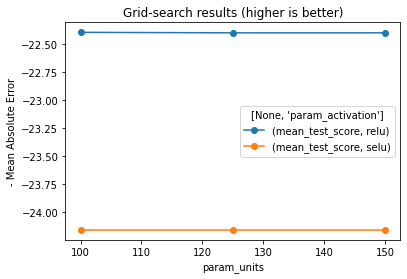

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_results(index='units', columns='activation'):
    index = 'param_' + index
    columns = 'param_' + columns

    # prepare the results into a pandas.DataFrame
    df = pd.DataFrame(grid.cv_results_)

    # Remove the other by selecting their best values (from gscv.best_params_)
    other = [c for c in df.columns if c[:6] == 'param_']
    other.remove(index)
    other.remove(columns)

    # Set all other parameters to their "top" values.
    for col in other:
        df = df[df[col] == grid.best_params_[col[6:]]]

    # Create pivot tables for easy plotting
    table_mean = df.pivot_table(index=index, columns=columns,
                                values=['mean_test_score'])
    
    # plot the pivot tables
    plt.figure()
    ax = plt.gca()
    for col_mean in table_mean.columns:
        table_mean[col_mean].plot(marker='o',label=col_mean)
    plt.title('Grid-search results (higher is better)')
    plt.ylabel('- Mean Absolute Error')
    plt.legend(title=table_mean.columns.names)
    plt.show()

plot_results(index='units', columns='activation')